# Thư viện và kết nối drive

---



In [1]:
import pandas, spacy, torch , random , math
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models

from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset , random_split

from PIL import Image
from torchvision.transforms import transforms


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Xử lý caption và ảnh

---



In [3]:
# Sử dụng thư viện spacy để lấy từ vựng tiếng anh
spacy_eng = spacy.load("en_core_web_sm")

image_root = "/content/drive/MyDrive/Dự án nguyên cứu/Computer Vision/datasets/Flickr8k/Images"
caption_root = "/content/drive/MyDrive/Dự án nguyên cứu/Computer Vision/datasets/Flickr8k/captions.txt"

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        """
            Decode và encode cho các thành phần đặc biệt
            <SOS> : start of sentence (bắt đầu một câu)
            <EOS> : end of sentence (kết thúc một câu)
            <PAD> : padding (khoảng cách một chữ)
            <UNK> : unkown word (các từ không nằm trong từ điển)
        """
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

        # Tuần số suất hiện của 1 từ cho phép thêm vào vocabulary
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    # Hàm lấy token (chữ cái) và in thường của một câu , hàm .text() định dạng về String
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    # Hàm xây dựng bộ từ điển dựa trên bộ data đưa vào bao gồm : training , testing
    def build_vocabulary(self,sentences):
        # từ đầu tiên trong bộ dữ liệu xuất phát từ vị trí thứ 4
        # 4 vị trí đầu cho thành phần đặc biệt
        idx = 4
        frequency = {}

        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    #Thêm từ vào từ điển và có value = 1 (vd : {'hello':1})
                    frequency[word] = 1
                else:
                    #Nếu từ đã có tăng value
                    frequency[word] += 1

                """
                  Nếu từ vừng vựng có tần số > tần số yêu cầu ,
                  đưa từ vựng vào mới vào decode và encode từ vựng
                  và tăng index
                  (vd : itos = {4: "hello"} , stoi = {"hello":4})
                """
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1

    # Hàm encoding chữ sang số
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)

        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]


In [5]:
annotation = pandas.read_csv(caption_root)
annotation.head(5)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
annotation['caption'].tolist()[:3]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .']

In [7]:
class FlickrDataset(Dataset):
    def __init__(self, image_path = None, caption_path = None,
                      freq_threshold=5, transform=None):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.image_path = image_path

        self.df = pandas.read_csv(caption_path)

        self.captions = self.df['caption']
        self.images = self.df['image']

        self.vocab = Vocabulary(freq_threshold)

        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]

        img = Image.open(self.image_path + "/" + image).convert("RGB")

        if (self.transform):
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]

        numericalized_caption += self.vocab.numericalize(caption)

        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)

        return img, targets

In [8]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225)),
        ]
    )

In [9]:
def get_loader(image_path= None, caption_path=None,
               transform = transform, batch_size = 16,
               num_workers = 2, shuffle = True, pin_memory = True):

    dataset = FlickrDataset(image_path= image_root, caption_path= caption_root
                            , transform = transform)

    train_size, test_size = int(len(dataset) * 0.8), len(dataset) - (int(len(dataset) * 0.8))
    trainset, testset = random_split(dataset,[train_size,test_size])

    pad_value = dataset.vocab.stoi["<PAD>"]

    trainloader = DataLoader(dataset = trainset, batch_size = batch_size
                , num_workers = num_workers, shuffle = shuffle
                , pin_memory = pin_memory, collate_fn = MyCollate(pad_value))

    testloader = DataLoader(dataset = testset, batch_size = 1
                , num_workers = 2, shuffle = shuffle
                , pin_memory = pin_memory, collate_fn = MyCollate(pad_value))

    return dataset , trainloader , trainset , testloader , testset

In [10]:
dataset , trainloader , trainset , testloader , testset = get_loader()

In [11]:
print(len(trainset),len(testset))
print(len(trainloader),len(testloader))
for idx,(image,caption) in enumerate(trainloader):
  print(f"idx = {idx} , image.size = {image.size()} , caption.size = {caption.size()}")
  break

32364 8091
2023 8091
idx = 0 , image.size = torch.Size([16, 3, 224, 224]) , caption.size = torch.Size([22, 16])


torch.Size([3, 224, 224]) torch.Size([15])
<SOS> santa claus leads some type of parade on an <UNK> looking vehicle . <EOS> 

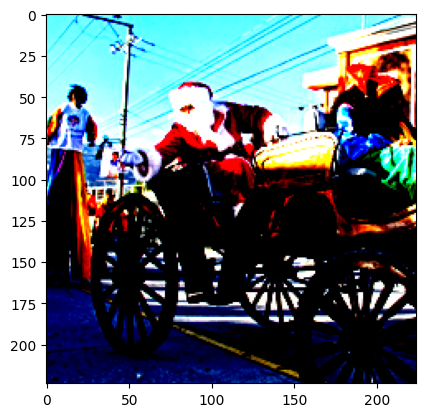

In [37]:
x, y = trainset[random.randint(0,100)]
print(x.shape, y.shape)
plt.imshow(x.permute(1,2,0))
# Decode caption
for i in y:
    print(dataset.vocab.itos[int(i)],end = " ")

# Xây dựng mô hình CNN2LSTM
---



In [22]:
class encoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(encoderCNN, self).__init__()

        # Sử dụng mô hình resnet
        resnet50 = models.resnet50(weights=True)
        # freeze tất cả các block
        for p in resnet50.parameters():
            p.requires_grad = False
        # Bỏ lớp cuối vì không dùng cho classification
        modules = list(resnet50.children())[:-1]

        self.resnet50 = nn.Sequential(*modules)

        self.embed_image = nn.Linear(resnet50.fc.in_features
                          , embed_size)

        self.relu = nn.ReLU()
        self.dropout= nn.Dropout(0.5)

    def forward(self, images):
        """
        images.shape = (batch_size, 3, 224, 224)
        """
        features = self.resnet50(images)   # (batch_size, 2048, 1, 1)
        features = features.view(features.size(0),-1)   # (batch_size, 2048*1*1)
        features = self.embed_image(features)   # (batch_size , embed_size)
        features = self.dropout(self.relu(features))

        return features

In [23]:
class decoderLSTM(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(decoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption))  # (caption_size , batch_size , embed_size)

        """
        Ban đầu : features.shape = (batch_size , embed_size)
        Unsqeeze(0) để features.shape bằng chiều với caption sau khi embedding
                : featrues.shape = (1 , batch_size , embed_size)
                  embeddings_caption.shape = (caption_size , batch_size , embed_size)
        Concat 2 ma trận features ảnh với embedding caption
               : (captions_size + 1 , batch_size , embed_size)
        """
        # Embedding features ảnh với caption
        # (caption_size + 1 , batch_size , embed_size)
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)

        hiddens, _ = self.lstm(embeddings)  # (caption_size + 1 , batch_size , hidden_size)
        outputs = self.linear(hiddens)    # (caption_size + 1 , batch_size , vocab_size)
        return outputs

In [24]:
class CNN2LSTM(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2LSTM, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderLSTM = decoderLSTM(embed_size, vocab_size,
                                       hidden_size, num_layers)

    def forward(self, images, caption):
        features = self.encoderCNN(images)
        x = self.decoderLSTM(features, caption)
        return x

    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []

        with torch.no_grad():
            # Chỉ dự đoán 1 ảnh , thêm batch = 1 cho phần encoder
            x = self.encoderCNN(image).unsqueeze(0)   # content vector (features image)
            states = None

            for _ in range(maxlength):
                # Hiddens state và Cell state của một node
                hiddens, states = self.decoderLSTM.lstm(x, states)  # Dùng input và cell state trước

                # Sử dụng Hidden để dự đoán từ hiện tại
                output = self.decoderLSTM.linear(hiddens.squeeze(0))

                predicted = output.argmax(1)      # Greedy Search

                result_caption.append(predicted.item())

                # Dự đoán từ tiếp theo bằng từ hiện tại
                x = self.decoderLSTM.embedding(
                    predicted.long()).unsqueeze(0)

                # Gặp token <EOS> thì dừng việc dự đoán
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]

Một LSTM cell

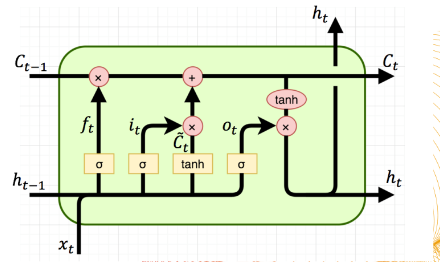

<h2><b>Huấn luyện mô hình</b></h2>

In [25]:
# Tham số lưu , có thực hiện huấn luyện mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
load_model = True
save_model = True
train_CNN2LSTM = False
cnn2lstm_checkpoint = "/content/drive/MyDrive/Dự án nguyên cứu/Computer Vision/checkpoint/cnn2lstm_checkpoint.pth.tar"

cuda


In [26]:
def save_checkpoint(state, checkpoint_root = None):
    print("saving checkpoint!")
    torch.save(state, checkpoint_root)

def load_checkpoint(checkpoint, model):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    step = checkpoint["step"]
    return step

In [27]:
import torch.optim as optim
# Siêu tham số huấn luyện mô hình
step = 0
embed_size = 400
hidden_size = 512
num_layers = 2
num_epochs = 10
learning_rate = 0.0001
vocab_size = len(dataset.vocab)

In [28]:
cnn2lstm = CNN2LSTM(
                embed_size = embed_size,
                hidden_size = hidden_size,
                vocab_size = vocab_size,
                num_layers = num_layers).to(device=device)

loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(cnn2lstm.parameters(), lr = learning_rate)

In [29]:
if load_model:
    step = load_checkpoint(
      torch.load(cnn2lstm_checkpoint, map_location = device), cnn2lstm)
    print(step)

loading checkpoint!
76874


In [30]:
if train_CNN2LSTM:

    cnn2lstm.train()

    for epoch in range(num_epochs):
        for idx, (imgs, captions) in enumerate(trainloader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            score = cnn2lstm(imgs, captions[:-1])

            optimizer.zero_grad()

            """
            score.shape = (captions_size + 1 , batch_size , embed_size)
            captions.shape =  (captions_size , batch_size)
            """
            loss = loss_criterion(score.reshape(-1, score.shape[2]),
                                  captions.reshape(-1))

            step += 1
            loss.backward()
            optimizer.step()
        print(f"Loss for epoch {epoch}: {loss}")

        if save_model:
          checkpoint = {
              "state_dict": cnn2lstm.state_dict(),
              "optimizer": cnn2lstm.state_dict(),
              "step": step,
          }
          save_checkpoint(checkpoint , cnn2lstm_checkpoint)

# Đánh giá mô hình CNN2LSTM

---



In [ ]:
from nltk.translate.bleu_score import SmoothingFunction , corpus_bleu

evaluated = False

if evaluated:

  predicted = []
  ground_truth = []

  cnn2lstm.eval()
  for idx, (imgs, captions) in enumerate(testloader):
      with torch.no_grad():
        imgs = imgs.to(device)
        ground_truth.append([dataset.vocab.itos[word]
                            for word in captions.view(-1).numpy()])
        predicted.append(cnn2lstm.captionImage(imgs,dataset.vocab))
        if (round(idx*100/len(testloader),2) % 10 == 0):
          print(f"{round(idx*100/len(testloader),2)}/100")

  chencherry = SmoothingFunction()
  bleu = corpus_bleu(ground_truth, predicted, smoothing_function=chencherry.method3)
  print(f"CNN2LSTM BLEU = {bleu}")

0.0/100
10.0/100
20.0/100
30.0/100
40.0/100
60.0/100
70.0/100
80.0/100
90.0/100
CNN2LSTM BLEU = 3.8149655182167956e-05


<h1><b>Testing trên 1 ảnh</b><h1>

<SOS> a young boy in a swimming pool . <EOS> 

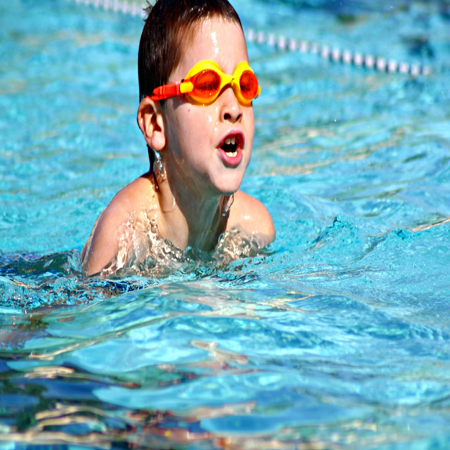

In [35]:
import PIL.Image , requests
from IPython.display import display

transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225)),

        ]
    )

#Lấy URL
url = "https://th.bing.com/th/id/R.0c69277a464c339cb0ddcd57575472b9?rik=sNHV5p%2fsbeln6g&pid=ImgRaw&r=0"
response = requests.get(url , stream = True)
# Mở ảnh
if response.status_code == 200:
  image = PIL.Image.open(response.raw)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  cnn2lstm.eval()
  with torch.no_grad():
    # Thực hiện captioning image
    caption = cnn2lstm.captionImage(
        transform(image).unsqueeze(0).to(device),
        dataset.vocab)

  for word in caption:
    print(word , end = " " )

  display(image.resize((450,450)))